In [24]:
import ast
import csv
import gc
import os
import subprocess
import sys
from sklearn.utils import shuffle 
import warnings
from collections import defaultdict
from timeit import default_timer as timer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import networkx
import numpy as np
import pandas as pd
import sklearn
import xgboost as xgb
from sklearn import *
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, log_loss, make_scorer,
                             roc_auc_score)
from sklearn.model_selection import (GridSearchCV, KFold, ParameterGrid,
                                     ParameterSampler, RandomizedSearchCV,
                                     StratifiedKFold, StratifiedShuffleSplit,
                                     cross_val_score, train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

import lightgbm as lgb
# from model import spam_ham
import json
from flask import (
	Flask,
	request
)
from importlib import import_module, reload
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn import datasets
from pipelinehelper import PipelineHelper
from sklearn.neighbors import KNeighborsClassifier
import pickle
from sklearn.linear_model import LogisticRegression
import requests
import base64
import json
import sys
import re,nltk
import tensorflow as tf
from nltk.corpus import stopwords
import string

In [427]:
data = pd.read_csv('../data/SPAM_Data.csv')
print(len(data))
print(data.Category.value_counts(normalize=True))
display(data.head(2))
data['Category'] = data['Category'].apply(lambda x: cat_map[x])

5572
ham     0.865937
spam    0.134063
Name: Category, dtype: float64


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...


In [180]:
test_size = 0.2
label = 0.2
def split_label_unlabel(data,label, test_size):
    training,test = train_test_split(data,test_size=test_size,random_state=100)
    unlabeled,train = train_test_split(training,test_size=label,random_state=100)
    return unlabeled, train,test

def to_pickle(obj, filename = None, **kwargs):

    if not filename:
        filename = tmpFilename(**kwargs) + ".pkl"

    import os

    try:
        folder = os.path.dirname(filename)
        os.mkdir(folder)
        print("Created folder:", folder)
    except:
        pass

    import pickle

    print("Writing pickle to", filename)
    with open(filename, 'wb') as fout:
        pickle.dump(obj, fout)

    return filename

In [430]:
pickle_path = '../models/'

cat_map = {
                "ham": 0,
                "spam": 1
            }
            
def data_processing(data):
    data['Message'] = data['Message'].apply(lambda x: str(x).strip().lower())
    translate_table = dict((ord(char), None) for char in string.punctuation)   
    data['Message'] = data['Message'].apply(lambda x: str(x).translate(translate_table))
    # print(data.head(2))    
    return data

def VectorizeText(data,stop_words={'english'},tf_idf_obj = None,fit = True):
    if fit:
        tf_idf = TfidfVectorizer(stop_words=stop_words)
        tf_idf.fit(list(data['Message']))
        features = tf_idf.transform(list(data['Message']))
        return features,tf_idf
    features = tf_idf_obj.transform(list(data['Message']))
    return features    

def fit(features,data):
    rf=LogisticRegression()
    rf.fit(features,data['Category'])
    # to_pickle(tf, os.path.join(pickle_path, 'rf.pkl'))
    return rf
        
def predict(model,feature,data = None,evaluation = False):
    # features = tf_idf.transform(list(data['Message']))
    pred = model.predict(feature)
    pred_prob = model.predict_proba(feature)[:,1]
    if evaluation:
        acc = accuracy_score(data.Category,pred)
        auc = sklearn.metrics.roc_auc_score(data.Category,pred)
        f1 = sklearn.metrics.f1_score(data.Category,pred)
        re = sklearn.metrics.recall_score(data.Category,pred)
        # print(f'Accuracy: {accuracy_score(data.Category,pred)}')
        # print(f'overall: {sklearn.metrics.classification_report(data.Category,pred)}')
        # print(f'AUC: {sklearn.metrics.roc_auc_score(data.Category,pred)}')
        return pred_prob,pred,acc,auc,f1,re
    return pred_prob,pred        

In [443]:
if __name__=='__main__':
    unlabeled, train,test = split_label_unlabel(data,label=0.2, test_size=0.2)
    print(train.shape)
    print(test.shape)
    print(unlabeled.shape)
    train = data_processing(train)
    test = data_processing(test)
    features,tf_idf = VectorizeText(train,stop_words={'english'})
    test_features = VectorizeText(test,tf_idf_obj = tf_idf,fit=False)
    model = fit(features,train)
    pred_prob,pred,acc,auc,f1,re = predict(model, test_features,data=test, evaluation = True)
print(f'f1 score {f1}')  
print(f'auc score {auc}') 
print(f'recall score {re}') 
print(f'accuracy score {acc}')



(892, 2)
(1115, 2)
(3565, 2)
f1 score 0.40217391304347827
auc score 0.6258503401360545
recall score 0.25170068027210885
accuracy score 0.9013452914798207


In [353]:
if __name__ == '__main__':

    # Initial split dataset into labeled(20 %)(with test 20 %) and unlabeled(80 %)
    
    # run both models 25 times and take the average of their accuracy
    auc1, auc2 = [], []  # lists to store auc of different models
    acc1, acc2 = [], []  # lists to store accuracy of different models
    f1_1, f1_2 = [], []  # lists to store f1 of different models
    re1,re2 = [], []  # lists to store recall of different models
    
    #starting condition
    def split_label_unlabel(data,label, test_size):
        training,test = train_test_split(data,test_size=test_size,random_state=100)
        unlabeled,train = train_test_split(training,test_size=label,random_state=100)
        return unlabeled, train,test
    label_size = 0.2
    unlabeled, train,test = split_label_unlabel(data,label=label_size, test_size=0.2)
    unlabeled = data_processing(unlabeled)
    train = data_processing(train)
    x_train = train['Message'].values
    y_train = train['Category'].values
    x_unlabeled = unlabeled['Message'].values
    y_unlabeled = unlabeled['Category'].values
    print(len(train))
    print(len(unlabeled))
    test = data_processing(test)
    al_label_added = []
    
    for i in range(25):
        print(f'active learning iteration:{i}')
        features,tf_idf1 = VectorizeText(train)
        test_features = VectorizeText(test,tf_idf_obj = tf_idf1,fit=False)
        unlabeled_features = VectorizeText(unlabeled,tf_idf_obj = tf_idf1,fit=False)
        model1 = fit(features,train)
        pred_prob,pred = predict(model1,unlabeled_features)

        #Uncertainty criteria for manual labeling
        p = 0.48            #uncertanity range 0.48 to 0.52
        uncrt_pt_ind = []
        for j in range(unlabeled.shape[0]):
            if(pred_prob[j] >= p and pred_prob[j] <= 1-p):
                uncrt_pt_ind.append(j)  
        uncrt_pt = len(uncrt_pt_ind)           
        print(f'new data points to be added based on uncertainty:{uncrt_pt}')
        al_label_added.append(uncrt_pt)
        
        #add new labeled data
        x_train = np.append(x_unlabeled[uncrt_pt_ind], x_train, axis = 0)
        y_train = np.append(y_unlabeled[uncrt_pt_ind], y_train)
        train = pd.DataFrame({'Message':list(x_train),'Category':list(y_train)})

        #retrain model with added labeled datapoints
        features,tf_idf2 = VectorizeText(train)
        model2 = fit(features,train)
        test_features = VectorizeText(test,tf_idf_obj = tf_idf2,fit=False)
        _,_,acc,auc,f1,re = predict(model2,test_features,test, evaluation = True)
        acc1.append(acc),auc1.append(auc),f1_1.append(f1),re1.append(re)

        #Break active learning loop if model performance saturates or uncertainty criteria doesn't meet
        if uncrt_pt == 0 or f1_1[max(0,(len(f1_1)-2))] > f1:
            break

        #train model with same no of train sample with random selection but without uncertainty sampling     
        ''' split dataset into train(same as generated),
        test(20 %), unlabel(rest) '''
        label_size += uncrt_pt/len(data)
        unlabeled_wo_active,train_wo_active,test_wo_active = split_label_unlabel(
            data, label=label_size, test_size=0.2)

        # train model without active learning
        train_wo_active = data_processing(train_wo_active)
        test_wo_active = data_processing(test_wo_active)
        features,tf_idf3 = VectorizeText(train_wo_active,stop_words={'english'})
        model3 = fit(features,train_wo_active)
        test_features = VectorizeText(test_wo_active,tf_idf_obj = tf_idf3,fit=False)
        _,_,acc,auc,f1,re = predict(model3, test_features,test_wo_active, evaluation = True)
        acc2.append(acc),auc2.append(auc),f1_2.append(f1),re2.append(re)


        

892
3565
active learning iteration:0
new data points to be added based on uncertainty:42
Accuracy: 0.9255605381165919
(925, 2)
Accuracy: 0.9022421524663677
active learning iteration:1
new data points to be added based on uncertainty:30
Accuracy: 0.9309417040358744
(949, 2)
Accuracy: 0.9040358744394619
active learning iteration:2
new data points to be added based on uncertainty:34
Accuracy: 0.9417040358744395
(977, 2)
Accuracy: 0.9040358744394619
active learning iteration:3
new data points to be added based on uncertainty:26
Accuracy: 0.947085201793722
(997, 2)
Accuracy: 0.9049327354260089
active learning iteration:4
new data points to be added based on uncertainty:22
Accuracy: 0.9524663677130045
(1015, 2)
Accuracy: 0.905829596412556
active learning iteration:5
new data points to be added based on uncertainty:9
Accuracy: 0.9524663677130045
(1022, 2)
Accuracy: 0.905829596412556
active learning iteration:6
new data points to be added based on uncertainty:14
Accuracy: 0.9515695067264573
Ac

In [347]:
print("Accuracy by active model :", np.mean(acc1)*100)
print("Accuracy by random sampling :", np.mean(acc2)*100)
print("AUC by active model :", np.mean(auc1)*100)
print("AUC by random sampling :", np.mean(auc2)*100)
print("f1 score by active model :", np.mean(f1_1)*100)
print("f1 score by random sampling :", np.mean(f1_2)*100)
print("recall score by active model :", np.mean(re1)*100)
print("recall score by random sampling :", np.mean(re2)*100)

Accuracy by active model : 94.80568011958145
Accuracy by random sampling : 90.56053811659191
AUC by active model : 80.66105746706396
AUC by random sampling : 64.20068027210885
f1 score by active model : 75.4017949105164
f1 score by random sampling : 44.2272863284325
recall score by active model : 61.45124716553286
recall score by random sampling : 28.40136054421769


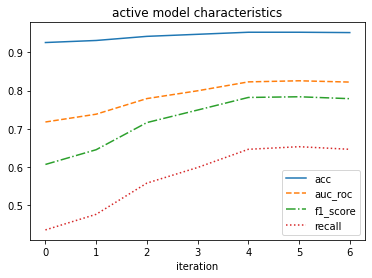

Text(0.5, 1.0, 'random sampling model characteristics')

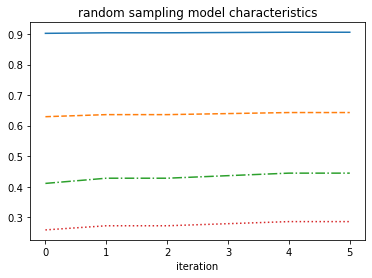

In [416]:
import matplotlib.pyplot as plt
import numpy as np

x = range(len(acc1))  
# plot lines

plt.plot(x, acc1, label = "acc", linestyle="-")
plt.plot(x, auc1, label = "auc_roc", linestyle="--")
plt.plot(x, f1_1, label = "f1_score", linestyle="-.")
plt.plot(x, re1, label = "recall", linestyle=":")
plt.xlabel('iteration')
plt.title('active model characteristics')
plt.legend()
plt.show()

x = range(len(acc2))
plt.plot(x, acc2, label = "acc", linestyle="-")
plt.plot(x, auc2, label = "auc_roc", linestyle="--")
plt.plot(x, f1_2, label = "f1_score", linestyle="-.")
plt.plot(x, re2, label = "recall", linestyle=":")
plt.xlabel('iteration')
plt.title('random sampling model characteristics')    


Text(0.5, 1.0, 'active model uncertainty characteristics')

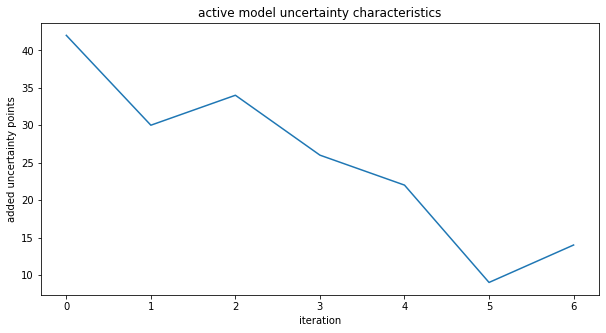

In [448]:
plt.figure(figsize=(10,5))
plt.plot(range(len(acc1)), al_label_added, label = "acc", linestyle="-")
plt.xlabel('iteration')
plt.ylabel('added uncertainty points')
plt.title('active model uncertainty characteristics')

## Using from modAL

In [ ]:
from modAL.models import ActiveLearner

# initializing the learner
learner = ActiveLearner(
    estimator=LogisticRegression(),
    X_training=features, y_training=y_train
)

# active learning pipeline
performance = []
n_queries = 100
for idx in range(n_queries):
    query_idx, query_instance = learner.query(test_features)
    print("query_idx : ", query_idx)  # index with most confusion
    print("prediction probability : ", learner.predict_proba(test_features[query_idx]), "prediction class : ", learner.predict(test_features[query_idx]))

    y_pred = learner.predict(valid_features)
    print(sklearn.metrics.classification_report(y_valid, y_pred))
    print(sklearn.metrics.f1_score(y_valid, y_pred))
    
    performance.append(sklearn.metrics.f1_score(y_valid, y_pred))
    learner.teach(test_features[query_idx].reshape(1, -1), y_test[query_idx])  # model trained on most confused data point
    
    test_features = np.delete(test_features, query_idx, 0)   # new test set X without the above trained data point
    y_test = np.delete(y_test, query_idx, 0)   # new test set y without the above trained data point


In [394]:
from modAL.models import ActiveLearner

# Initial split dataset into labeled(20 %)(with test 20 %) and unlabeled(80 %)
unlabeled, labeled, test =split_label_unlabel(data,label=label_size, test_size=0.2)

#Feature preprocess
unlabeled = data_processing(unlabeled)
labeled = data_processing(labeled)
test = data_processing(test)
x_train = labeled['Message'].values
y_train = labeled['Category'].values
x_test = unlabeled['Message'].values
y_test = unlabeled['Category'].values
x_valid = test['Message'].values
y_valid = test['Category'].values
features,tf_idf1 = VectorizeText(labeled)
features = features.toarray()
test_features = VectorizeText(unlabeled,tf_idf_obj = tf_idf1,fit=False).toarray()
valid_features = VectorizeText(test,tf_idf_obj = tf_idf1,fit=False).toarray()

# initializing the learner
learner = ActiveLearner(
    estimator=LogisticRegression(),
    X_training=features, y_training=y_train
)

In [398]:
# active learning
performance = []
n_queries = 100
for idx in range(n_queries):
    query_idx, query_instance = learner.query(test_features)
    print("query_idx : ", query_idx)  # index with most confusion
    print("prediction probability : ", learner.predict_proba(test_features[query_idx]), "prediction class : ", learner.predict(test_features[query_idx]))

    y_pred = learner.predict(valid_features)
    print(sklearn.metrics.classification_report(y_valid, y_pred))
    print(sklearn.metrics.f1_score(y_valid, y_pred))
    
    performance.append(sklearn.metrics.f1_score(y_valid, y_pred))
    learner.teach(test_features[query_idx].reshape(1, -1), y_test[query_idx])  # model trained on most confused data point
    
    test_features = np.delete(test_features, query_idx, 0)   # new test set X without the above trained data point
    y_test = np.delete(y_test, query_idx, 0)   # new test set y without the above trained data point


query_idx :  [3286]
prediction probability :  [[0.50070976 0.49929024]] prediction class :  [0]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       968
           1       1.00      0.29      0.44       147

    accuracy                           0.91      1115
   macro avg       0.95      0.64      0.70      1115
weighted avg       0.92      0.91      0.88      1115

0.4444444444444445
query_idx :  [1691]
prediction probability :  [[0.50124402 0.49875598]] prediction class :  [0]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       968
           1       1.00      0.29      0.45       147

    accuracy                           0.91      1115
   macro avg       0.95      0.65      0.70      1115
weighted avg       0.92      0.91      0.88      1115

0.4526315789473684
query_idx :  [1611]
prediction probability :  [[0.49979023 0.50020977]] prediction class :  [1]
              precis

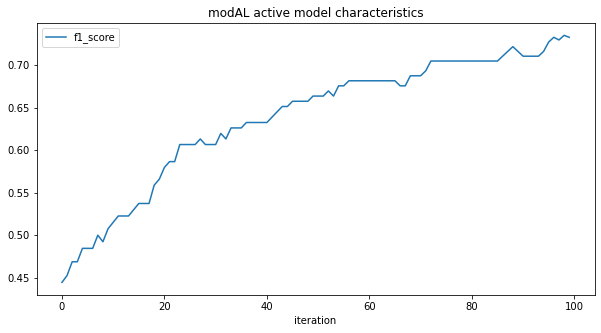

f1 score: 0.7327586206896551


In [452]:
plt.figure(figsize=(10,5))
plt.plot(range(len(performance)), performance, label = "f1_score", linestyle="-")
plt.xlabel('iteration')
plt.title('modAL active model characteristics')
plt.legend()
plt.show()
print(f'f1 score: {sklearn.metrics.f1_score(y_valid, y_pred)}')